In [95]:
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [96]:
def save_picture(filename, source):
  image = Image.fromarray(np.uint8(source))
  image.save(filename, dpi=(200, 200))

def BGR2HSI(img):
    m, n = img.shape[:2]
    hsi_img = img.copy()
    B, G, R = cv.split(img)
    [B, G ,R] = [ i / 255.0 for i in ([B, G, R])]
    H = np.zeros((m, n))
    S = np.zeros((m, n))
    I = (R + G + B) / 3.0
    for i in range(m):
        numerator = 0.5 * (R[i] - B[i] + R[i] - G[i])
        denominator = np.sqrt((R[i] - G[i]) ** 2+(R[i] - B[i]) * (G[i] - B[i]))
        theta = np.arccos(numerator/denominator)
        h = np.zeros(n)
        h[B[i] <= G[i]] = theta[B[i] <= G[i]]
        h[G[i] < B[i]] = 2 * np.pi - theta[G[i] < B[i]]
        h[denominator == 0] = 0
        H[i] = h/(2 * np.pi)

    for i in range(m):
        for j in range(n):
            if I[i][j] == 0:
                S[i][j] = 0
            else:
                S[i][j] = 1 - min(R[i][j], B[i][j], G[i][j]) / I[i][j]

    hsi_img[:,:,0] = H * 255
    hsi_img[:,:,1] = S * 255
    hsi_img[:,:,2] = I * 255
    return hsi_img

def HSI2BGR(img):
    m, n = img.shape[:2]
    bgr_img = img.copy()
    H,S,I = cv.split(img)
    [H,S,I] = [ i / 255.0 for i in ([H,S,I])]

    B = np.zeros((m, n))
    G = np.zeros((m, n))
    R = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            h = H[i][j] * 2 * np.pi
            if(h >= 0 and h < 2 * np.pi / 3):
                B[i][j] = I[i][j] * (1 - S[i][j])
                R[i][j] = I[i][j]*(1 + S[i][j] * np.cos(h) / np.cos(np.pi / 3 - h))
                G[i][j] = 3*I[i][j]- R[i][j] - B[i][j]
            
            elif(h >= 2 * np.pi / 3 and h < 4 * np.pi / 3):
                h = h - 2 * np.pi / 3
                R[i][j] = I[i][j] * (1 - S[i][j])
                G[i][j] = I[i][j] * (1 + S[i][j] * np.cos(h) / np.cos(np.pi / 3 - h))
                B[i][j] = 3 * I[i][j] - R[i][j] - G[i][j]
            
            elif(h >= 4 * np.pi / 3 and 2 * np.pi):
                h = h - 4 * np.pi / 3
                G[i][j] = I[i][j] * (1 - S[i][j])
                B[i][j] = I[i][j] * (1 + S[i][j] * np.cos(h) / np.cos(np.pi / 3 - h))
                R[i][j] = 3 * I[i][j] - G[i][j] - B[i][j]
                
    bgr_img[:,:,0] = B * 255
    bgr_img[:,:,1] = G * 255
    bgr_img[:,:,2] = R * 255
    return bgr_img

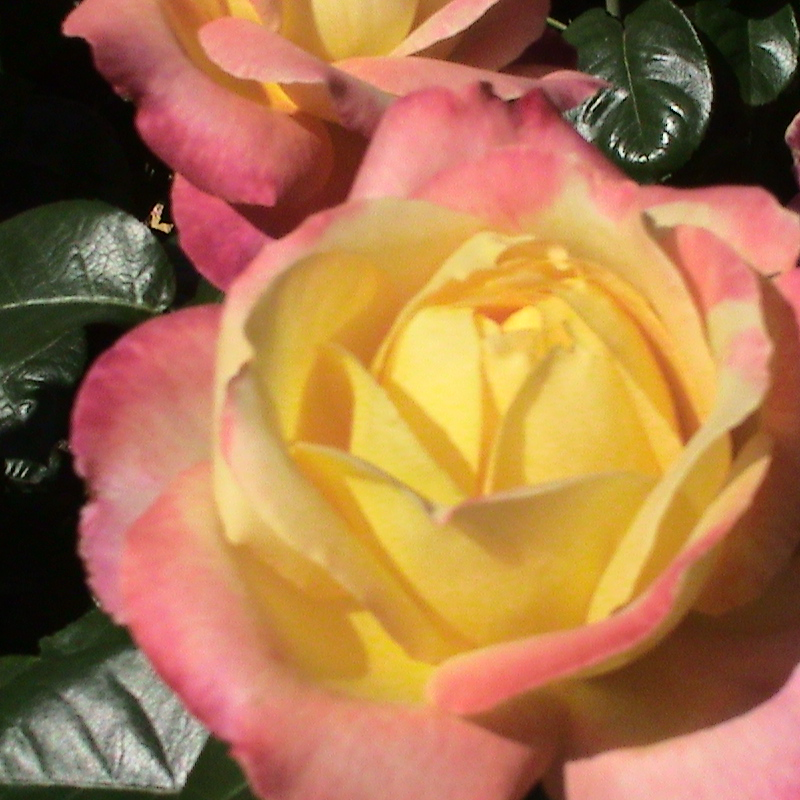

In [97]:
img = cv.imread('LovePeace rose.tif')
cv2_imshow(img)

In [98]:
B,G,R = cv.split(img)
save_picture('R.png', R)
save_picture('G.png', G)
save_picture('B.png', B)

<ipython-input-96-5f3b9e01c796>:16: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(numerator/denominator)
<ipython-input-96-5f3b9e01c796>:16: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(numerator/denominator)


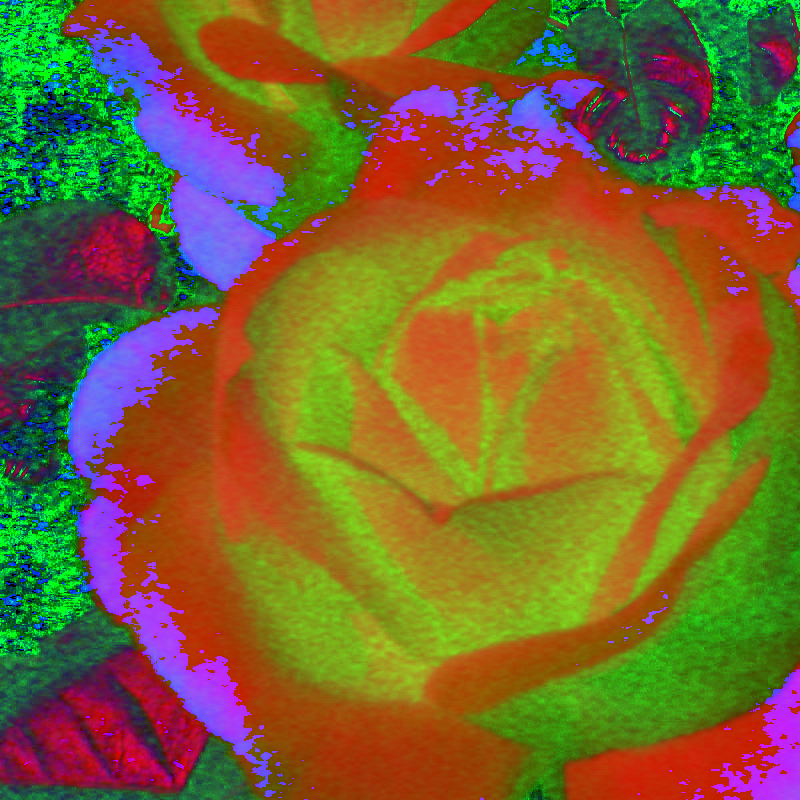

In [99]:
HSI = BGR2HSI(img)
cv2_imshow(HSI)

In [100]:
H,S,I = cv.split(HSI)
save_picture('H.png', H)
save_picture('S.png', S)
save_picture('I.png', I)

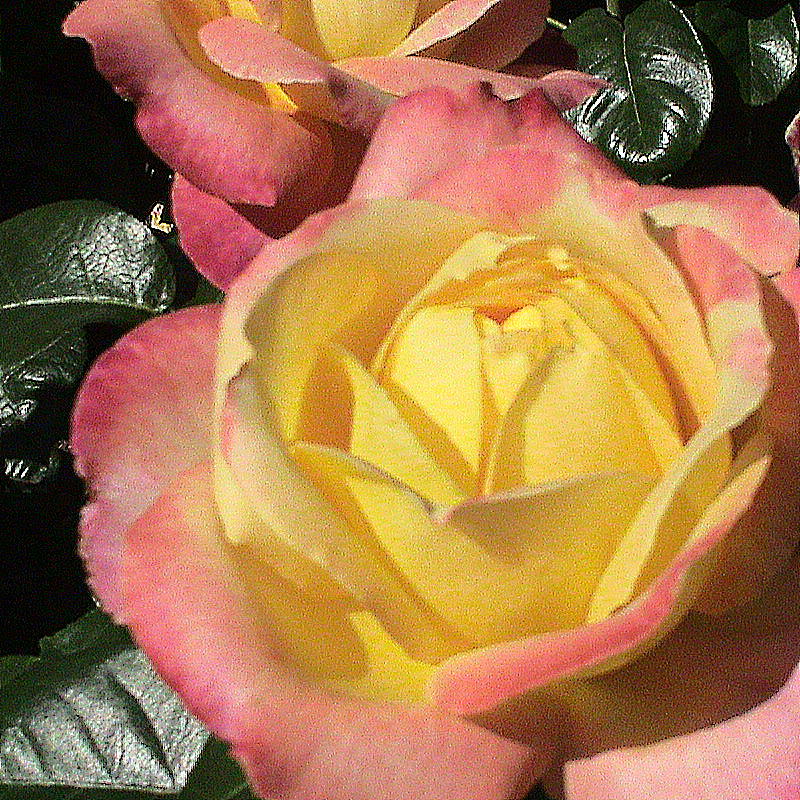

In [101]:
#RGB sharpening

kernel = np.array([[-1, -1, -1],
           [-1,  9, -1],
           [-1, -1, -1]], dtype = np.double)

R_filtered = cv.filter2D(R, ddepth = -1, kernel=kernel, borderType=cv.BORDER_DEFAULT)
G_filtered = cv.filter2D(G, ddepth = -1, kernel=kernel, borderType=cv.BORDER_DEFAULT)
B_filtered = cv.filter2D(B, ddepth = -1, kernel=kernel, borderType=cv.BORDER_DEFAULT)

BGR_sharpen = cv.merge([B_filtered, G_filtered, R_filtered])
cv2_imshow(BGR_sharpen)
save_picture('RGB_sharpened.png', cv.cvtColor(BGR_sharpen, cv.COLOR_BGR2RGB))

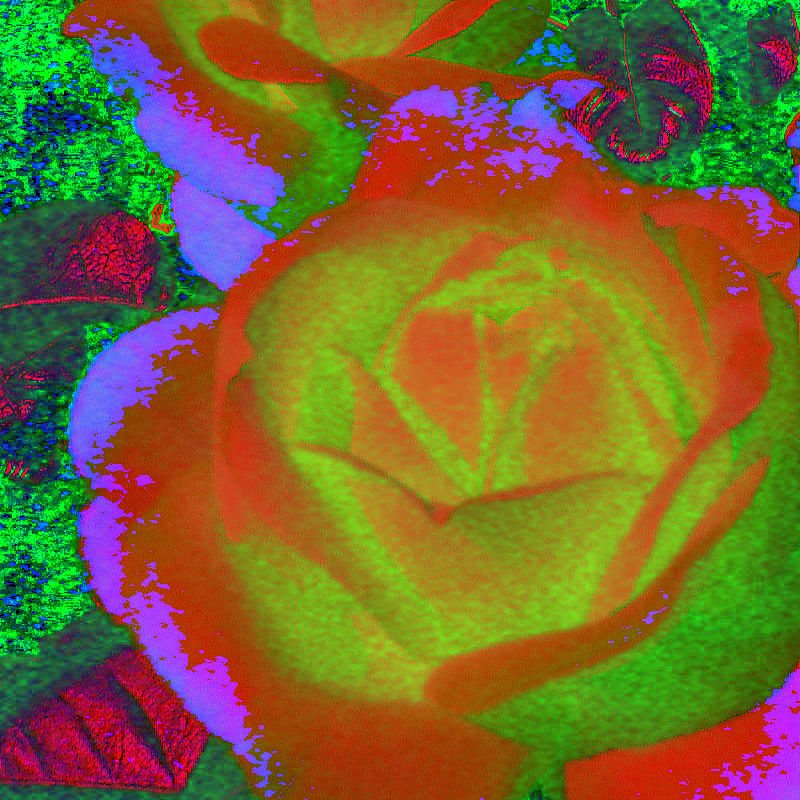

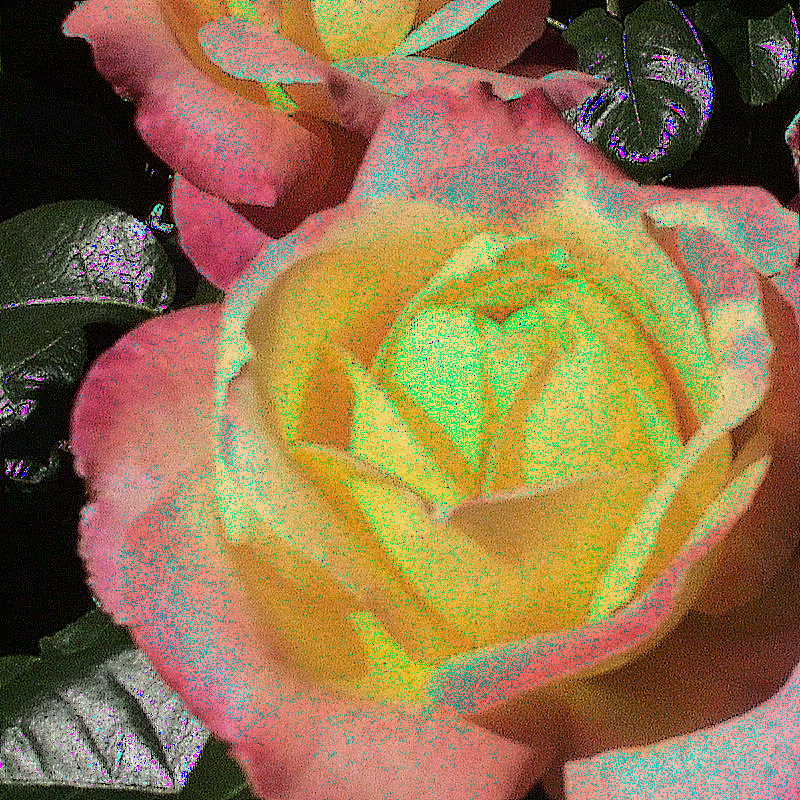

In [102]:
#HSI sharpening
I_filtered = cv.filter2D(I, ddepth = -1, kernel=kernel, borderType=cv.BORDER_DEFAULT)

HSI_sharpen = cv.merge([H, S, I_filtered])
cv2_imshow(HSI_sharpen)
HSI_sharpen2BGR = HSI2BGR(HSI_sharpen)
cv2_imshow(HSI_sharpen2BGR)
save_picture('HSI_sharpened.png', cv.cvtColor(HSI_sharpen2BGR, cv.COLOR_BGR2RGB))

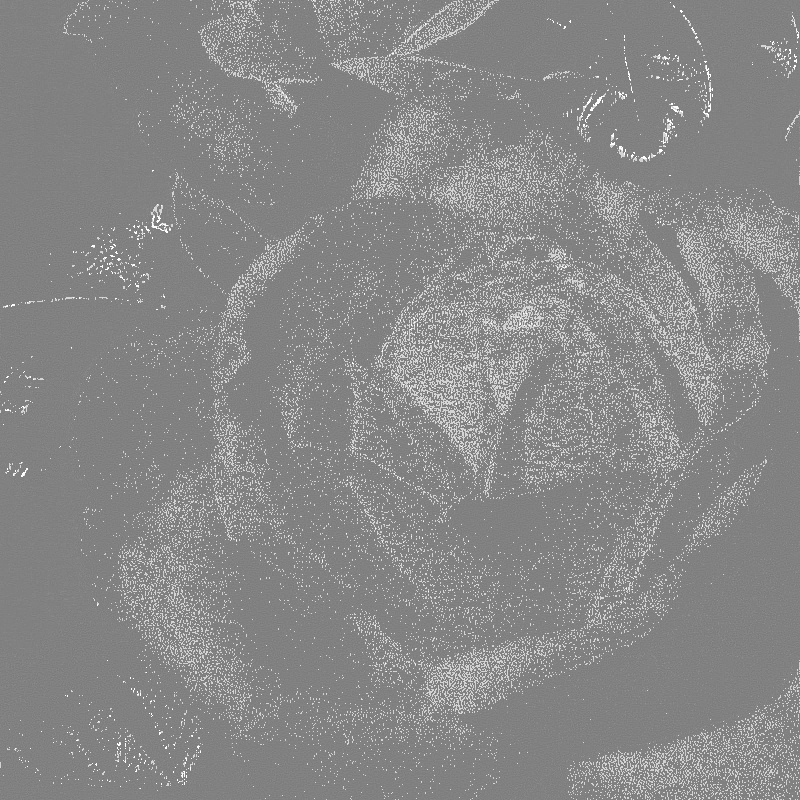

In [103]:
#difference the image
diff_img = np.zeros((img.shape[0], img.shape[1]))


for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        deltaB = int(BGR_sharpen[i][j][0]) - int(HSI_sharpen2BGR[i][j][0])
        deltaG = int(BGR_sharpen[i][j][1]) - int(HSI_sharpen2BGR[i][j][1])
        deltaR = int(BGR_sharpen[i][j][2]) - int(HSI_sharpen2BGR[i][j][2])
        diff_img[i][j] = (deltaB + deltaG + deltaR) / 3 + 128

cv2_imshow((diff_img))
save_picture('diff_img.png', diff_img)